In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

In [2]:
class Sphere():
    def __init__(self, n, pos, vel, rad, mass):
        self.n = n
        self.pos = pos
        self.vel = vel
        self.rad = rad
        self.mass = mass

    def update(self, new_pos, new_vel):
        self.pos = new_pos
        self.vel = new_vel

def initial_state(nr, positions, velocities, rad, mass):
    IS = []
    for n in range(nr):
        IS.append(Sphere(n,positions[n], velocities[n], rad[n], mass[n]))
    return IS

def check_collision(i,j):
    r = i.pos - j.pos
    v = i.vel - j.vel
    rnorm = np.linalg.norm(r)
    rnorm2 = rnorm*rnorm
    rv = np.dot(r,v)
    rv2 = rv*rv
    vnorm2 = np.linalg.norm(v)*np.linalg.norm(v)
    s = abs(i.rad + j.rad)
    s2 = s*s
    if s < rnorm: #condition 1, eq5
        if rv < 0: # condition 2, eq6
            if rnorm2-rv2/vnorm2 < s2: #condition 3, eq7
                dt = (rnorm2 - s2) / (-rv + np.sqrt(rv2 - (rnorm2-s2)*vnorm2 ))
                if dt > 0:
                    return dt
    return None

#### below is yet to be incorportated in simulation ####
def wall_collisions(l, i):
    # collisions with lXl square wall centered at (0,0)
    dts = []
    wall = []

    if i.vel[0] == 0 and i.vel[1] ==0:
        return None, None
    else:
        # collision with left wall
        if i.vel[0] < 0:
            rx = -(i.pos[0]-i.rad + l/2)
            dt = rx/i.vel[0]
            dts.append(dt)
            wall.append('left')
        elif i.vel[0] > 0:  
            # collision with right wall
            rx = l/2 - (i.pos[0]+i.rad)
            dt = rx/i.vel[0]
            dts.append(dt)
            wall.append('right')
        
        # collision with top wall
        if i.vel[1] > 0:
            ry = l/2 - (i.pos[1]+i.rad)
            dt = ry/i.vel[1]
            dts.append(dt)
            wall.append('top')
        elif i.vel[1] < 0:
            # collision with bottom wall
            ry = -(i.pos[1]-i.rad + l/2)
            dt = ry/i.vel[1]
            dts.append(dt)
            wall.append('bottom')
        
        w = wall[np.argmin(dts)]
        dtw = min(dts)

        return dtw, w

def create_heap(IS):
    heap_list = []
    for i in IS:
        dtw, w = wall_collisions(10,i)
        if dtw != None:
            heap_list.append((dtw,0,i.n,i,w))
        for jn in range(i.n+1,len(IS)):
            j = IS[jn]
            dt = check_collision(i,j)
            if dt != None:
                heap_list.append((dt,0,i.n,i,j))
    
    heapq.heapify(heap_list)
    return heap_list


In [3]:
IS = initial_state(4, [np.array([0,0]), np.array([0,1]), np.array([1,0]), np.array([1,1])], [np.array([-1,0]), np.array([0,0]), np.array([0,-1]), np.array([0,0])], 0.1*np.ones(4),0.1*np.ones(4))
heap = create_heap(IS)
print(heap)
heapq.heappush(heap, (0.5, 0, 1))
print(heap)
heapq.heappop(heap)
print(heap)

[(4.9, 0, 0, <__main__.Sphere object at 0x7f3c37267790>, 'left'), (4.9, 0, 2, <__main__.Sphere object at 0x7f3c372678e0>, 'bottom')]
[(0.5, 0, 1), (4.9, 0, 2, <__main__.Sphere object at 0x7f3c372678e0>, 'bottom'), (4.9, 0, 0, <__main__.Sphere object at 0x7f3c37267790>, 'left')]
[(4.9, 0, 0, <__main__.Sphere object at 0x7f3c37267790>, 'left'), (4.9, 0, 2, <__main__.Sphere object at 0x7f3c372678e0>, 'bottom')]


In [4]:
def collision(entry):
    # computes new positions and velocities for collison entry in heap
    dt = entry[0] - entry[1] # col time - time included in heap
    
    if not isinstance(entry[4], str):
        # new positions
        posi = entry[3].pos + entry[3].vel*dt
        posj = entry[4].pos + entry[4].vel*dt
        
        # new velocities
        reduced_mass = 2 / (1/entry[3].mass + 1/entry[4].mass) # eq. 12
        unit_vec = (entry[3].pos - entry[4].pos) / (entry[3].rad + entry[4].rad) # eq. 13
        mom_change = reduced_mass*np.dot(unit_vec, entry[3].vel - entry[4].vel)*unit_vec # eq. 12
        veli = entry[3].vel - mom_change/entry[3].mass # eq. 10
        velj = entry[4].vel + mom_change/entry[4].mass # eq. 11

        return posi, veli, posj, velj
    else:
        posi = entry[3].pos + entry[3].vel*dt
        if entry[4] == 'bottom' or entry[4] == 'top':
            veli = np.array([entry[3].vel[0],-entry[3].vel[1]])
        else:
            veli = np.array([-entry[3].vel[0],entry[3].vel[1]])
        
        return posi, veli, None, None



In [5]:
#### initialise state and run collisions up to time T ####
#### throws up error due to lack of wall ####

T = 1
IS = initial_state(4, [np.array([0,0]), np.array([0,1]), np.array([1,0]), np.array([1,1])], [np.array([0,1]), np.array([0,0]), np.array([0,1.2]), np.array([0,0])], 0.1*np.ones(4),0.1*np.ones(4))
L = -np.ones(len(IS)) # last collision time for each atom
simulation = []
heap = create_heap(IS)

t = 0
while t < T:
    print(t)
    # possible collision
    entry = heapq.heappop(heap)
    
    if not isinstance(entry[4],str):
        # checking if collision is valid event
        if entry[1] < L[entry[3].n]:
            pass
        elif entry[1] < L[entry[4].n]:
            pass
        else: # collision valid
            
            # updating last collision times
            L[entry[3].n] = entry[0]
            L[entry[4].n] = entry[0]
            
            # new particle pos and vel
            posi, veli, posj, velj = collision(entry)
            
            #save previous pos and vel
            simulation.append([entry[0], entry[3].n, entry[4].n, posi, posj, veli, velj])

            # update pos and vel
            entry[3].update(posi, veli)
            entry[4].update(posj, velj) # this will change all heap pos and vels
            # may not matter as they're no longer be valid?
            
            # update heap
            for i in IS:
                # collisions with first sphere
                dt = check_collision(i, entry[3])
                if dt != None:
                    heapq.heappush(heap, (dt + entry[0],entry[0],i.n,i, entry[3]))
                # collisions with second
                dt = check_collision(i, entry[4])
                if dt != None:
                    heapq.heappush(heap, (dt + entry[0],entry[0],i.n,i, entry[4]))
            
            #update heap with wall collissions
            dtw, w = wall_collisions(10,entry[3])
            if dtw != None:
                heapq.heappush(heap,(dtw + entry[0],entry[0],entry[3].n,entry[3],w))
            dtw, w = wall_collisions(10,entry[4])
            if dtw != None:
                heapq.heappush(heap,(dtw + entry[0],entry[0],entry[4].n,entry[4],w))
                    
            # update time counter
            t = entry[0]
    else:
        # checking if collision is valid event
        if entry[1] < L[entry[3].n]:
            pass
        else: # collision valid
            
            # updating last collision times
            L[entry[3].n] = entry[0]
            
            # new particle pos and vel
            posi, veli, posj, velj = collision(entry)
            
            #save previous pos and vel
            simulation.append([entry[0], entry[3].n, posi, veli, entry[4]])

            # update pos and vel
            entry[3].update(posi, veli)
            
            # update heap
            for i in IS:
                # collisions with first sphere
                dt = check_collision(i, entry[3])
                if dt != None:
                    heapq.heappush(heap, (dt + entry[0],entry[0],i.n, i, entry[3]))
            
            #update heap with wall collissions
            dtw, w = wall_collisions(10,entry[3])
            if dtw != None:
                heapq.heappush(heap,(dtw + entry[0],entry[0],entry[3].n,entry[3],w))
                
            # update time counter
            t = entry[0]

0
0.6666666666666665
0.7966666666666665
0.7999999999999998
0.8645833333333331
0.9559999999999998


In [6]:
print(simulation)

[[0.6666666666666665, 2, 3, array([1. , 0.8]), array([1., 1.]), array([  0. , -28.8]), array([ 0., 30.])], [0.7966666666666665, 3, array([1. , 4.9]), array([  0., -30.]), 'top'], [0.7999999999999998, 0, 1, array([0. , 0.8]), array([0., 1.]), array([  0., -24.]), array([ 0., 25.])], [0.8645833333333331, 2, array([ 1. , -4.9]), array([ 0. , 28.8]), 'bottom'], [0.9559999999999998, 1, array([0. , 4.9]), array([  0., -25.]), 'top'], [1.0278486394557822, 3, 2, array([1.        , 0.00204082]), array([ 1.        , -0.19795918]), array([     0. , 141148.8]), array([      0., -141150.])]]


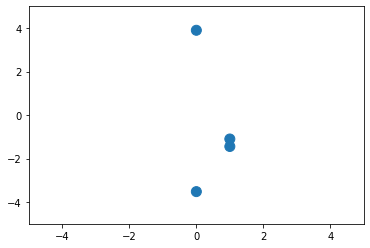

In [7]:
import matplotlib.animation as animation

inputs_nr = 4
inputs_pos = [np.array([0.,0.]), np.array([0.,1.]), np.array([1.,0.]), np.array([1.,1.])]
inputs_vel =  [np.array([0,1]), np.array([0,0]), np.array([0,1.2]), np.array([0,0])]
inputs_rad = 0.1*np.ones(4)
inputs_mass = 0.1*np.ones(4)
sim_info = simulation.copy()

l = 10
T = 1
steps = 50

pos = np.array(inputs_pos)
vel = np.array(inputs_vel)
rad = inputs_rad

dt = T/steps

xx = pos[:,0]
yy = pos[:,1]
pts_rad = 1000*rad

fig, ax = plt.subplots()
points = ax.scatter(xx,yy,s = pts_rad)
ax.set_ylim(-l/2,l/2)
ax.set_xlim(-l/2,l/2)

def update(i):
    global pos, vel
    
    sim = sim_info[0]
    t = dt*i
    if t > sim[0]:
        if len(sim)==7:
            pos[sim[1],:] = sim[3]
            pos[sim[2],:] = sim[4]
            vel[sim[1],:] = sim[5]
            vel[sim[2],:] = sim[6]
        else:
            pos[sim[1],:] = sim[2]
            vel[sim[1],:] = sim[3]
        sim_info.pop(0)
    
    pos = pos + vel*dt

    xx = pos[:,0]
    yy = pos[:,1]
    ax.clear()
    ax.scatter(xx,yy,s = pts_rad)
    ax.set_ylim(-l/2,l/2)
    ax.set_xlim(-l/2,l/2)

def generate_points():
    ax.scatter(xx,yy)

ani = animation.FuncAnimation(fig, update, init_func=generate_points, frames = steps, interval = T)
ani.save('animation.gif', writer='imagemagick', fps=4);